# **Setting**

In [1]:
import os
import warnings
warnings.filterwarnings('ignore')                       # warning 출력 false

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.adam import Adam

from torchvision.datasets.cifar import CIFAR10
from torch.utils.data.dataloader import DataLoader

import torchvision.transforms as T
from torchvision.transforms import Compose
from torchvision.transforms import RandomCrop, RandomHorizontalFlip, Normalize, ToTensor, Resize

## ***! Note ResNet(2016) [Click](https://arxiv.org/abs/1512.03385)***

* hidden layer를 깊게 쌓을수록 성능이 좋아질까? ***No***
    * 문제 1. 기울기 소실 문제(Gradient Vanishing)
    * 문제 2. 과적합 문제(Overfitting)
    * 문제 3. layer가 깊어질수록 feature maps 큰 특징만을 잡게 된다.
* 해결 과정
    * Conv → Batch Normalization → ReLU 여러번 반복<br>***Why?*** *Batch마다의 분포가 다른경우가 생겨 이를 해결하기 위해 사용. 모든 batch를 같은 분포로 만든다.*
    * input으로 들어온 채널을 기억해 두었다가 output에 더한다.(skip connection)***How?*** *Down Sampling*


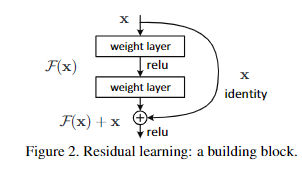

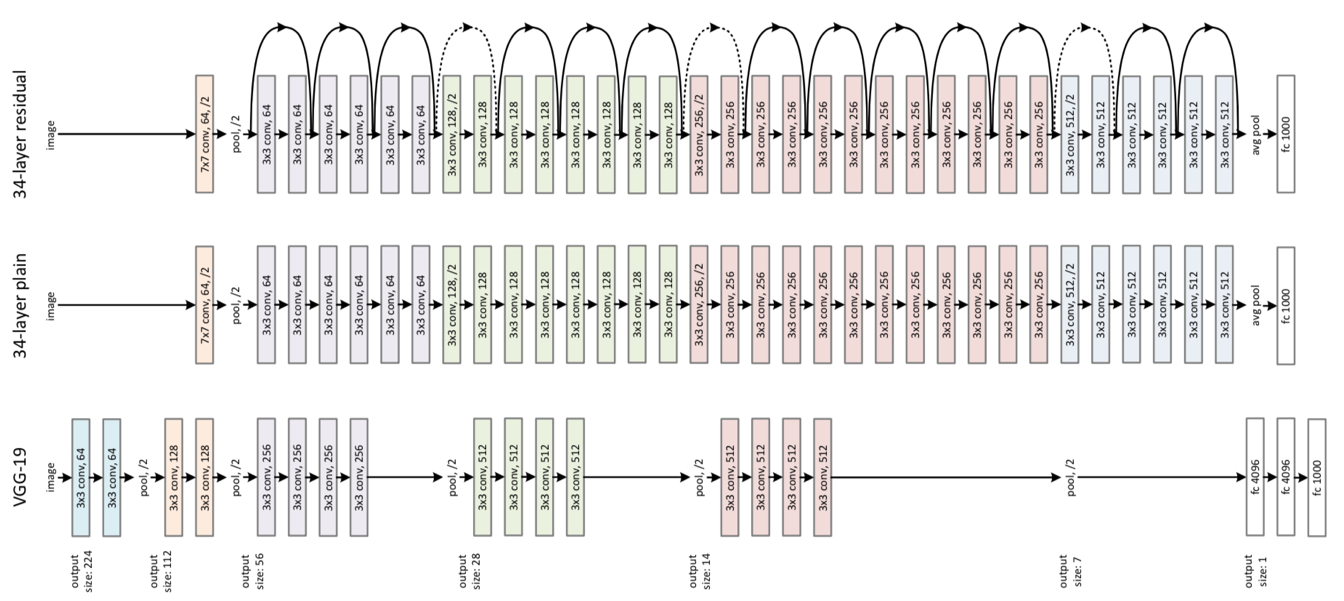

## ***! Point***
1. 배치 정규화(Batch Normalization)를 하는 이유?
2. 스킵 커넥션(Skip connection)을 하는 이유?
3. 다운 샘플링(Down Sampling)을 하는 이유?

# **1. 데이터 불러오기**

In [27]:
data_transforms = Compose(
    [
        Resize(32),
        RandomCrop((32,32),padding=4),
        RandomHorizontalFlip(p=0.5),
        T.ToTensor(),
        Normalize(mean=(0.4914, 0.4822, 0.4465),std=(0.247,0.243,0.261))
    ]
)

# 데이터 전처리
train_data = CIFAR10(root='./', train=True, download=True, transform=data_transforms)
test_data = CIFAR10(root='./', train=False, download=True, transform=data_transforms)

Files already downloaded and verified
Files already downloaded and verified


In [28]:
print(f'데이터 크기={train_data.data[0].shape}')

데이터 크기=(32, 32, 3)


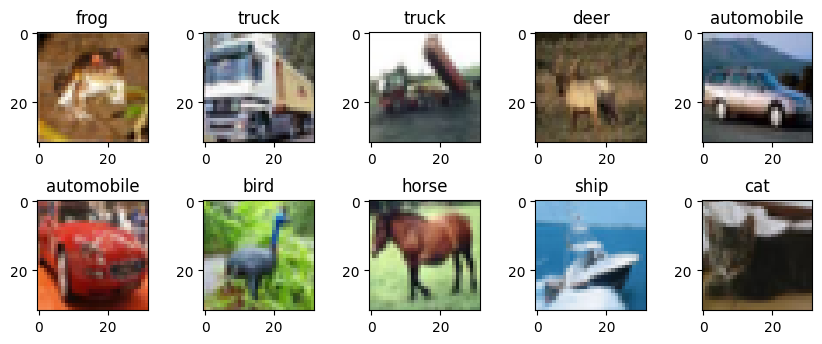

In [29]:
fig = plt.figure(figsize=(10, 4))
plt.subplots_adjust(wspace=0.5)

for i in range(10):
    idx = train_data.targets[i]
    ax = plt.subplot(2,5,i+1)
    ax.imshow(train_data.data[i])
    ax.set_title(train_data.classes[idx])

In [30]:
# DataLoader
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [31]:
data, label = next(iter(train_loader))
print(f'train_data = {data.shape}   label_data = {label.shape}')

train_data = torch.Size([32, 3, 32, 32])   label_data = torch.Size([32])


# **모델 설정**

In [7]:
# gpu 쓸 수 있는지 check
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


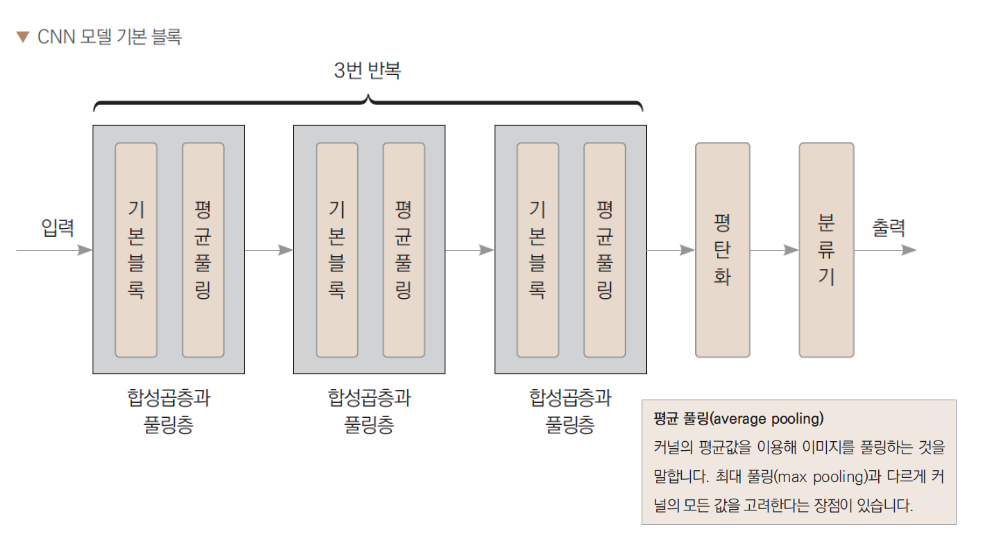

In [19]:
# basic block : save input - Conv3x3 - Batch Normalization - ReLU - Conv3x3 - Batch Normalization - skip connection - ReLU

class BasicBlock(nn.Module):
    def __init__(self,in_channels,out_channels,kernel_size=3):
        super(BasicBlock, self).__init__()

        self.conv1 = nn.Conv2d(in_channels,out_channels,kernel_size,padding=1)
        self.conv2 = nn.Conv2d(out_channels,out_channels,kernel_size,padding=1)

        self.downsample = nn.Conv2d(in_channels,out_channels,kernel_size=1)

        self.bn1 = nn.BatchNorm2d(num_features=out_channels)
        self.bn2 = nn.BatchNorm2d(num_features=out_channels)

        self.relu = nn.ReLU()

    def forward(self, x):
        x_ = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x_ = self.downsample(x_)    # down sampling
        x += x_                     # skip connection
        x = self.relu(x)

        return x

In [22]:
class ResNet(nn.Module):
    def __init__(self, num_classes=10):
        super(ResNet,self).__init__()

        self.block1 = BasicBlock(in_channels=3,out_channels=64)
        self.block2 = BasicBlock(in_channels=64,out_channels=128)
        self.block3 = BasicBlock(in_channels=128,out_channels=256)

        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)

        self.fc1 = nn.Linear(in_features=4096,out_features=2048)
        self.fc2 = nn.Linear(in_features=2048,out_features=512)
        self.fc3 = nn.Linear(in_features=512,out_features=num_classes)

        self.relu = nn.ReLU()

    def forward(self,x):
        x = self.block1(x)
        x = self.pool(x)

        x = self.block2(x)
        x = self.pool(x)

        x = self.block3(x)
        x = self.pool(x)

        x = torch.flatten(x,start_dim=1)

        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        x = self.fc3(x)

        return x

In [23]:
model = ResNet()
model.to(device)

ResNet(
  (block1): BasicBlock(
    (conv1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downsample): Conv2d(3, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (block2): BasicBlock(
    (conv1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (downsample): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
  )
  (block3): BasicBlock(
    (conv1): Conv2d(128, 256, kernel_size=(3, 3), stri

In [14]:
# ! pip install torchsummary

In [24]:
from torchsummary import summary
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4           [-1, 64, 32, 32]          36,928
       BatchNorm2d-5           [-1, 64, 32, 32]             128
            Conv2d-6           [-1, 64, 32, 32]             256
              ReLU-7           [-1, 64, 32, 32]               0
        BasicBlock-8           [-1, 64, 32, 32]               0
         AvgPool2d-9           [-1, 64, 16, 16]               0
           Conv2d-10          [-1, 128, 16, 16]          73,856
      BatchNorm2d-11          [-1, 128, 16, 16]             256
             ReLU-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 128, 16, 16]         147,584
      BatchNorm2d-14          [-1, 128,

## ***! Note 차원 직접 계산하기***
```
input 32 * 32 * 3

layer 1 (32 - 3 + 2) + 1 = 32 -> 32 * 32 *  64
layer 2 (32 - 3 + 2) + 1 = 32 -> 32 * 32 *  64
layer 3  32 / 2 = 16          -> 16 * 16 *  64

layer 1 (16 - 3 + 2) + 1 = 16 -> 16 * 16 *  128
layer 2 (16 - 3 + 2) + 1 = 16 -> 16 * 16 *  128
layer 3  16 / 2 = 8           ->  8 *  8 * 128

layer 1 ( 8 - 3 + 2) + 1 =  8 ->  8 *  8 * 256
layer 2 ( 8 - 3 + 2) + 1 =  8 ->  8 *  8 * 256
layer 3   8 / 4 = 2           ->  4 *  4 * 256

flatten 4 * 4 * 256 = 4096
```

# **3. 모델 학습**

In [34]:
from tqdm import tqdm

optim = Adam(model.parameters(), lr=1e-3)
epochs = 10

for epoch in range(epochs):
    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)

        optim.zero_grad()
        pred = model(data)
        loss = nn.CrossEntropyLoss()(pred, label)
        loss.backward()
        optim.step()

    print(f'epoch = {epoch + 1}, loss = {loss.item()}')

100%|██████████| 1563/1563 [00:35<00:00, 44.29it/s]


epoch = 1, loss = 0.845694363117218


100%|██████████| 1563/1563 [00:36<00:00, 43.40it/s]


epoch = 2, loss = 0.4554549753665924


100%|██████████| 1563/1563 [00:36<00:00, 42.84it/s]


epoch = 3, loss = 0.5562663674354553


100%|██████████| 1563/1563 [00:36<00:00, 42.29it/s]


epoch = 4, loss = 1.0018229484558105


100%|██████████| 1563/1563 [00:36<00:00, 43.11it/s]


epoch = 5, loss = 0.252331405878067


100%|██████████| 1563/1563 [00:35<00:00, 43.97it/s]


epoch = 6, loss = 0.2246709018945694


100%|██████████| 1563/1563 [00:37<00:00, 41.75it/s]


epoch = 7, loss = 0.13620513677597046


100%|██████████| 1563/1563 [00:36<00:00, 42.32it/s]


epoch = 8, loss = 0.22482995688915253


100%|██████████| 1563/1563 [00:36<00:00, 42.72it/s]


epoch = 9, loss = 0.13578009605407715


100%|██████████| 1563/1563 [00:37<00:00, 41.88it/s]

epoch = 10, loss = 0.10569679737091064


# **4. 모델 예측**

In [35]:
model.eval()

pred_list = []
with torch.no_grad():
    total_corr = 0

    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        preds = model(images)
        _, pred = torch.max(preds.data, 1)
        pred_list.extend(pred)

        corr = pred.eq(labels).sum().item()
        total_corr += corr
        print(corr, end=' ')

    print()
    print(f'Accuracy = {total_corr / len(test_data)}')

31 23 29 30 26 26 29 27 28 26 32 29 26 26 29 29 30 27 30 30 28 27 26 28 26 28 27 27 28 28 27 27 28 28 30 24 28 30 27 29 24 27 31 27 29 27 25 26 26 26 28 28 25 29 26 28 29 28 27 27 26 27 27 27 28 28 27 25 29 25 25 25 27 27 28 26 27 28 27 28 27 29 27 27 26 31 28 28 27 29 28 29 28 29 27 28 28 27 29 29 23 28 30 24 26 31 28 25 30 27 29 28 26 25 28 28 26 26 25 30 30 26 30 29 27 27 27 31 28 27 28 29 28 28 24 30 28 27 29 28 28 28 24 29 22 28 29 25 24 26 28 27 29 28 27 24 28 30 27 28 27 27 25 27 29 27 26 30 30 27 27 30 27 30 29 28 28 29 23 27 32 26 26 26 25 31 29 28 30 28 30 26 29 28 27 27 30 29 28 28 27 26 30 27 29 24 28 26 29 29 26 27 30 27 24 28 25 28 26 30 30 26 28 29 26 29 31 28 27 31 27 23 24 29 29 29 26 27 29 27 28 30 28 24 27 28 29 28 26 29 28 30 27 28 29 28 28 31 27 26 27 28 30 28 25 25 27 26 26 27 29 27 26 28 25 25 29 28 31 26 28 28 28 29 28 28 31 30 24 30 27 29 25 29 23 28 29 27 29 29 31 28 26 30 26 30 25 28 28 30 30 27 15 
Accuracy = 0.863


In [73]:
print(train_data.data.shape)
print(train_data.targets)

(50000, 32, 32, 3)
[6, 9, 9, 4, 1, 1, 2, 7, 8, 3, 4, 7, 7, 2, 9, 9, 9, 3, 2, 6, 4, 3, 6, 6, 2, 6, 3, 5, 4, 0, 0, 9, 1, 3, 4, 0, 3, 7, 3, 3, 5, 2, 2, 7, 1, 1, 1, 2, 2, 0, 9, 5, 7, 9, 2, 2, 5, 2, 4, 3, 1, 1, 8, 2, 1, 1, 4, 9, 7, 8, 5, 9, 6, 7, 3, 1, 9, 0, 3, 1, 3, 5, 4, 5, 7, 7, 4, 7, 9, 4, 2, 3, 8, 0, 1, 6, 1, 1, 4, 1, 8, 3, 9, 6, 6, 1, 8, 5, 2, 9, 9, 8, 1, 7, 7, 0, 0, 6, 9, 1, 2, 2, 9, 2, 6, 6, 1, 9, 5, 0, 4, 7, 6, 7, 1, 8, 1, 1, 2, 8, 1, 3, 3, 6, 2, 4, 9, 9, 5, 4, 3, 6, 7, 4, 6, 8, 5, 5, 4, 3, 1, 8, 4, 7, 6, 0, 9, 5, 1, 3, 8, 2, 7, 5, 3, 4, 1, 5, 7, 0, 4, 7, 5, 5, 1, 0, 9, 6, 9, 0, 8, 7, 8, 8, 2, 5, 2, 3, 5, 0, 6, 1, 9, 3, 6, 9, 1, 3, 9, 6, 6, 7, 1, 0, 9, 5, 8, 5, 2, 9, 0, 8, 8, 0, 6, 9, 1, 1, 6, 3, 7, 6, 6, 0, 6, 6, 1, 7, 1, 5, 8, 3, 6, 6, 8, 6, 8, 4, 6, 6, 1, 3, 8, 3, 4, 1, 7, 1, 3, 8, 5, 1, 1, 4, 0, 9, 3, 7, 4, 9, 9, 2, 4, 9, 9, 1, 0, 5, 9, 0, 8, 2, 1, 2, 0, 5, 6, 3, 2, 7, 8, 8, 6, 0, 7, 9, 4, 5, 6, 4, 2, 1, 1, 2, 1, 5, 9, 9, 0, 8, 4, 1, 1, 6, 3, 3, 9, 0, 7, 9, 7, 7, 9, 1, 5, 1, 6,

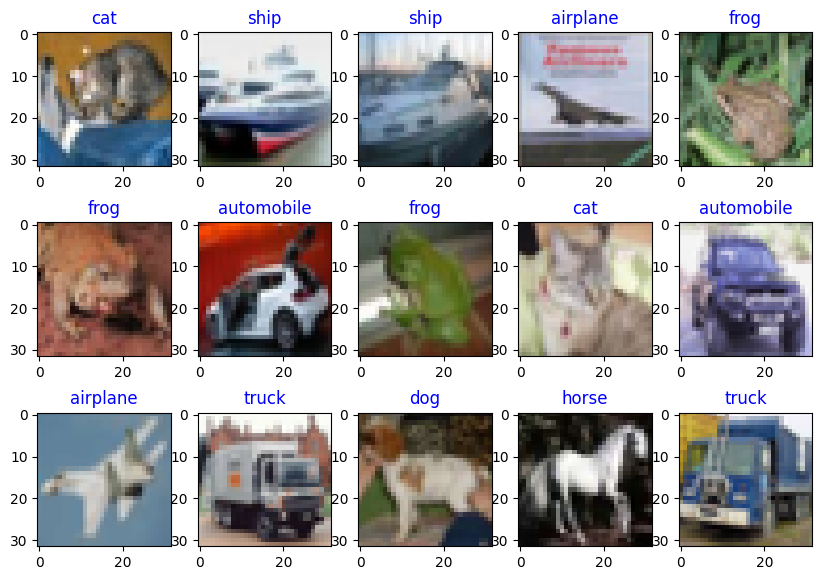

In [81]:
class_names = train_data.classes

fig = plt.figure(figsize=(10, 7))
for i, (X, y) in enumerate(zip(test_data.data, test_data.targets)):
    # X = X.numpy().transpose((1,2,0))
    ax = plt.subplot(3, 5, i+1)
    yhat = pred_list[i]
    if y == yhat:
        color = 'blue'
        title = class_names[y]
    else:
        color = 'red'
        title = f'{class_names[y]}({class_names[yhat]})'

    ax.imshow(X)
    ax.set_title(title, color=color)

    if i+1 == 15:
        break